In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37725/status,
Dashboard: http://127.0.0.1:37725/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33663,Workers: 2
Dashboard: http://127.0.0.1:37725/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:38727,Total threads: 4
Dashboard: http://127.0.0.1:37247/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:37581,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
baseline_product = 'landsat_8'
baseline_measurement = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

analysis_product = 'landsat_8'
analysis_measurement = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Run data for St Maarten Baseline
baseline_dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat_baseline/'
baseline_ds = prep_dataset(baseline_dir, baseline_measurement, baseline_product, clip_coords)

## Run data for the Tile7572 baseline
# baseline_dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# baseline_ds = prep_dataset(baseline_dir, baseline_measurement, baseline_product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 4, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2018-11-09 ... 2018-03-14
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

In [6]:
# St Maarten Analysis
analysis_dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat_analysis/'
analysis_ds = prep_dataset(analysis_dir, analysis_measurement, analysis_product, clip_coords)

# # Run data for the Tile7572 analysis
# analysis_dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/AnalysisData/'
# analysis_ds = prep_dataset(analysis_dir, analysis_measurement, analysis_product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 3, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2022-11-20 2022-12-22 2022-10-19
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), met

## Cloud and Water Masking
Get just the areas of water from the image.

In [7]:
# Use the landsat clean mask function to mask out clouds and land.
water_baseline = ls_clean_mask(baseline_ds, keep_water=True)
water_analysis = ls_clean_mask(analysis_ds, keep_water=True)

## Create Water Mask Composites

In [8]:
# Take the mean of the water observations over time 
water_baseline_mean = water_baseline.mean(dim='time')
water_analysis_mean = water_analysis.mean(dim='time')

# Use stack arrays with composite time handling to align composites before calculations.
water_analysis_mean, water_baseline_mean = stack_arrays([water_analysis_mean, water_baseline_mean], water_analysis_mean, time_handling='Composites')


### Visualize Water Composites

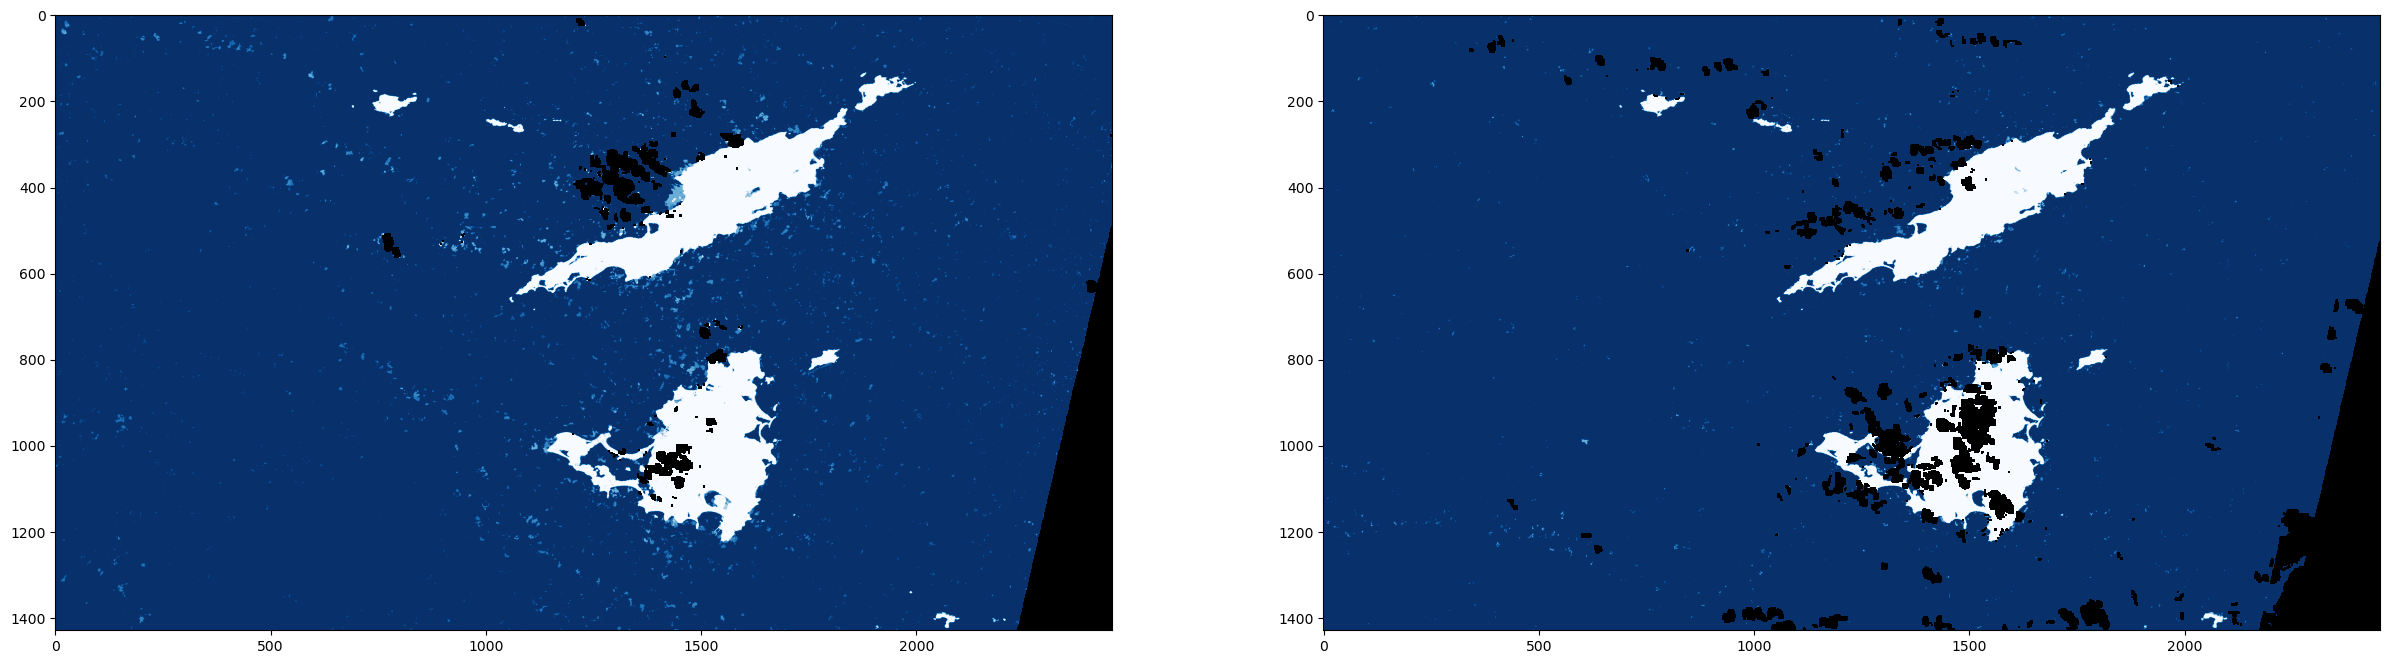

In [9]:
import matplotlib
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('Blues')
cmap.set_bad(color='black')
ax[0].imshow(water_baseline_mean.squeeze(), cmap=cmap)
ax[1].imshow(water_analysis_mean.squeeze(), cmap=cmap)

## Difference Range Product

In [10]:
# Calculate between the two water composites to find change in water.
difference_range = water_analysis_mean - water_baseline_mean

# Filter to show only valid values.
difference_range = difference_range.where((water_baseline_mean != -9999) & (water_analysis_mean != -9999) & (difference_range >= -1))

## Difference Threshold Product
Set a water threshold value to use in classifying water from non-water. Then classify the mean water composites based on whether the pixels are less than or greater than this threshold value. If the pixel value is greater than the threshold (i.e. if the pixel is water), the value in the output will be 1 to indicate water, and all other areas will have a value of 0 to indicate non-water.

In [11]:
# Define a value to set as the threshold for classifying water from non-water.
waterThresh = 0.1

# Classify baseline water composites based on threshold value.
T0_nd_water = np.isnan(water_baseline_mean)
wc_baseline_rc_int = water_baseline_mean.where((water_baseline_mean < waterThresh) | (T0_nd_water == True), 1) 
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterThresh) | (T0_nd_water == True), 0) 

# Classify analysis water composites based on threshold value.
T1_nd_water = np.isnan(water_analysis_mean)
wc_analysis_rc_int = water_analysis_mean.where((water_analysis_mean < waterThresh) | (T1_nd_water == True), 1) 
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterThresh) | (T1_nd_water == True), 0) 

# Calculate the difference between the two thresholded water composites.
difference_thresh = wc_analysis_rc - wc_baseline_rc

### Visualize Thresholded Water Composites

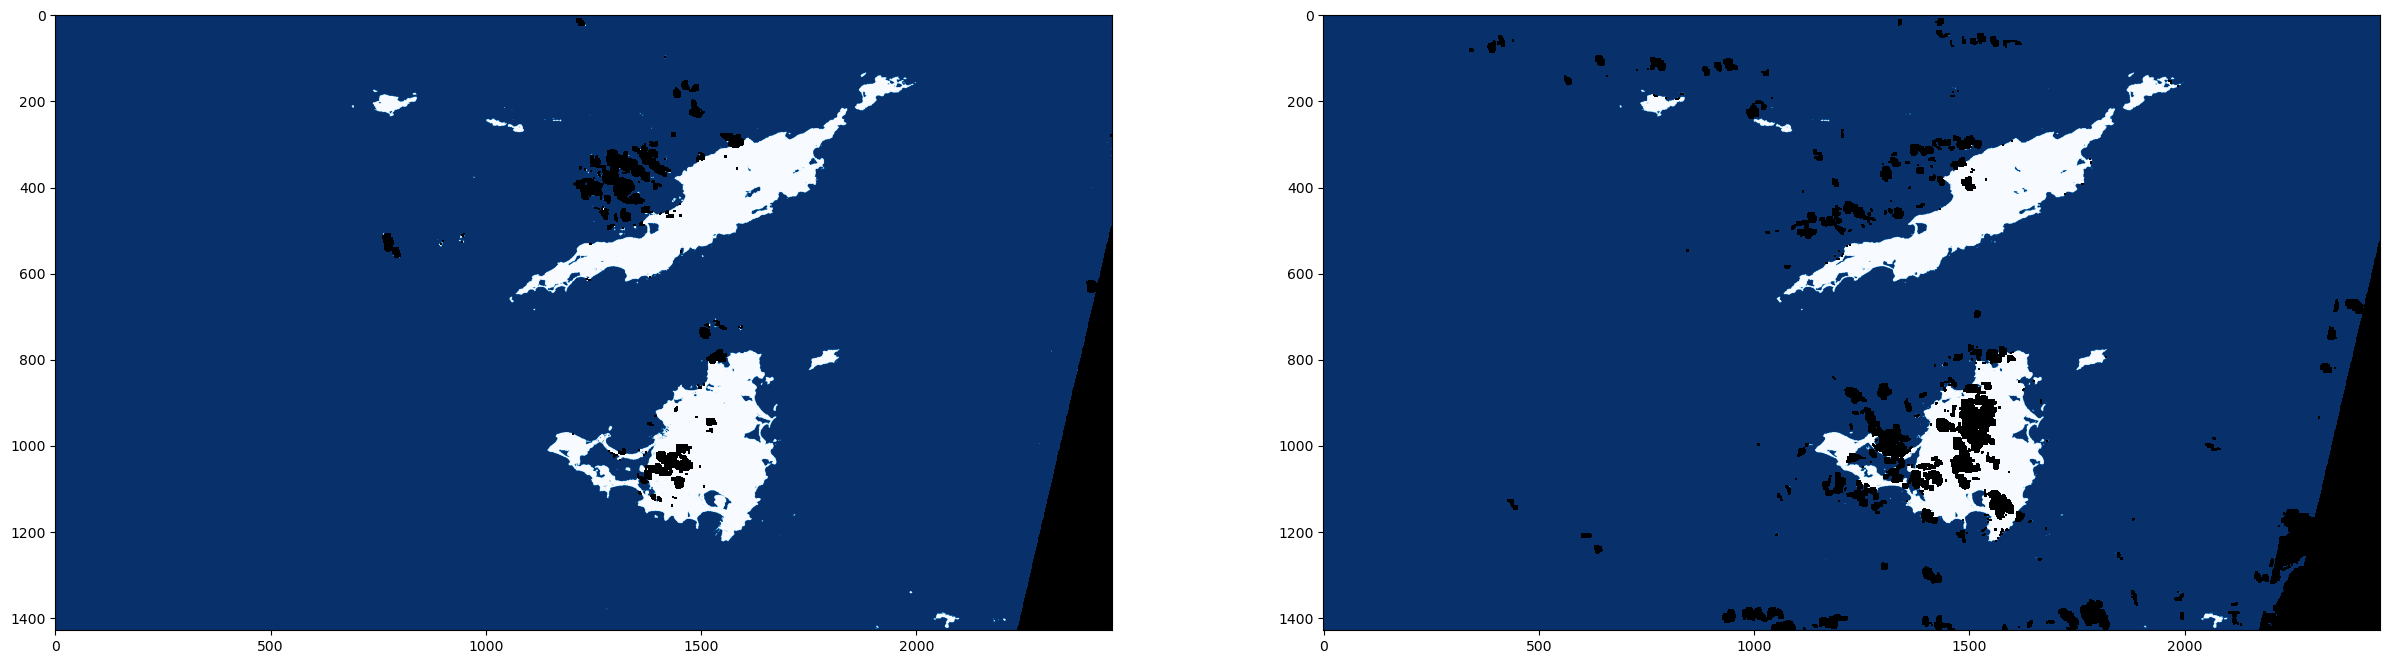

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('Blues')
cmap.set_bad(color='black')
ax[0].imshow(wc_baseline_rc.squeeze(), cmap=cmap)
ax[1].imshow(wc_analysis_rc.squeeze(), cmap=cmap)

### Visualize Difference Products

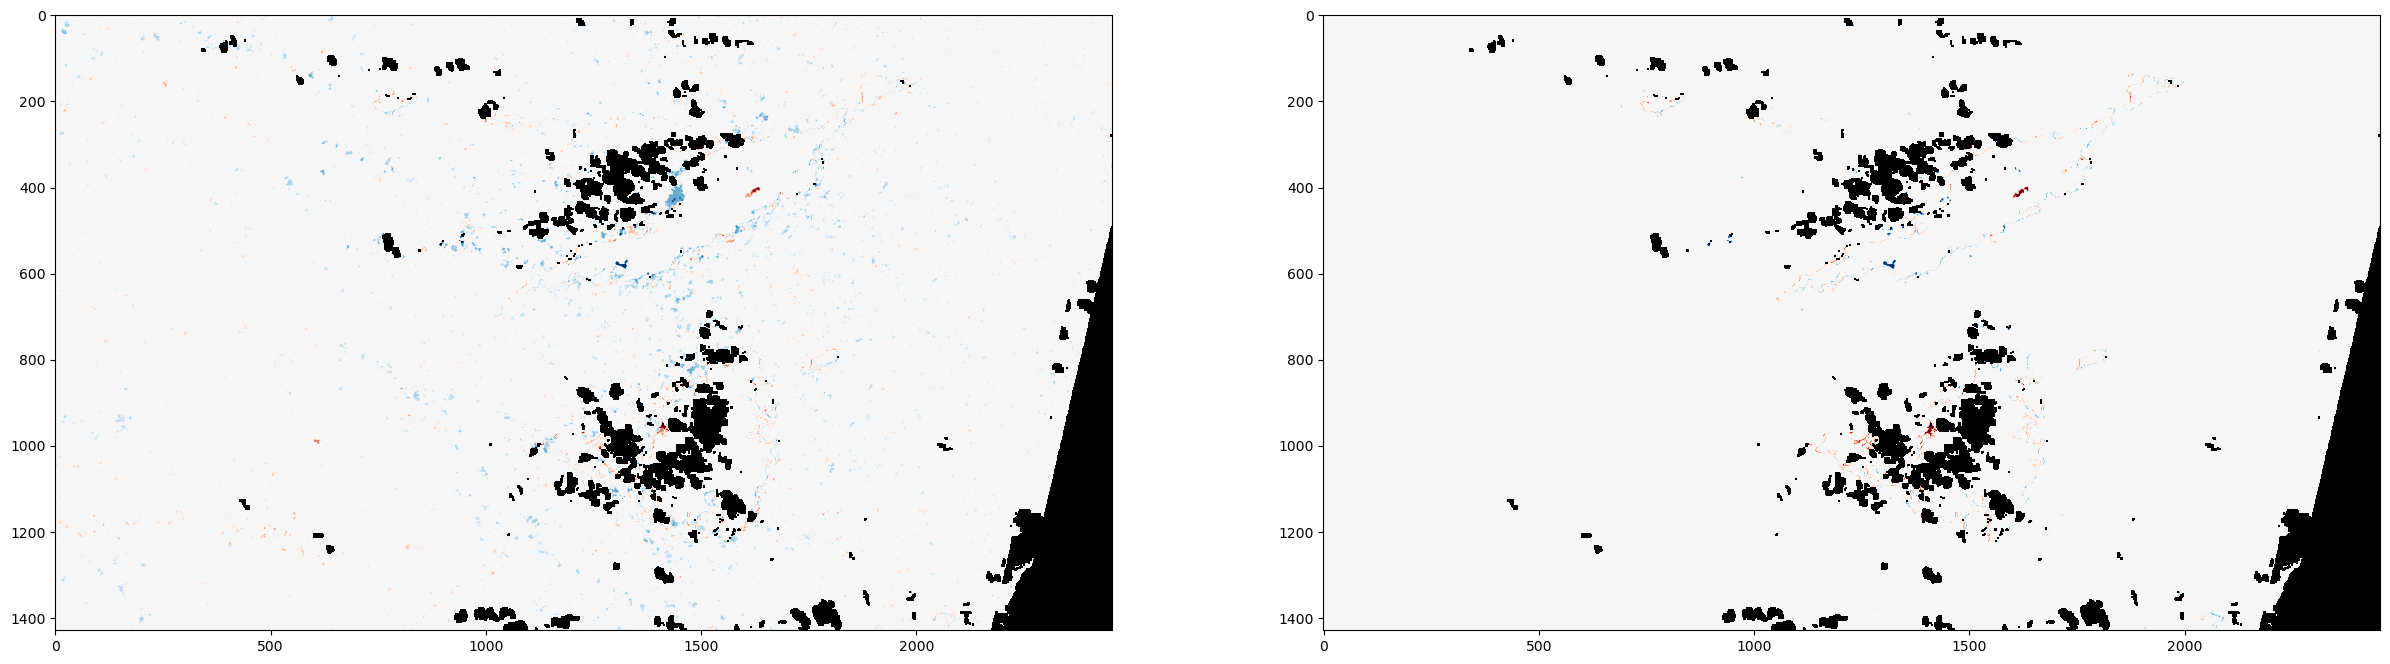

2024-01-11 11:20:01,288 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:45037', name: 1, status: running, memory: 0, processing: 0>
2024-01-11 11:20:08,384 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45037'.
2024-01-11 11:20:08,437 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:45037'. Shutting down.
2024-01-11 11:20:08,449 - distributed.core - INFO - Connection to tcp://127.0.0.1:33663 has been closed.


In [13]:
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('RdBu')
cmap.set_bad(color='black')
ax[0].imshow(difference_range, cmap=cmap)
ax[1].imshow(difference_thresh, cmap=cmap)

## Export Desired Data

In [51]:
# Export the Difference Range Data
water_analysis_mean.rio.to_raster('StMaarten_WaterComposite_Analysis.tif', dtype='float32', driver='COG')
water_baseline_mean.rio.to_raster('StMaarten_WaterComposite_Baseline.tif', dtype='float32', driver='COG')
difference_range.rio.to_raster('StMaarten_DifferenceRange.tif', dtype='float32', driver='COG')

# Export the Difference Threshold Data
wc_analysis_rc.rio.to_raster('StMaarten_WaterThreshold_Analysis.tif', dtype='float32', driver='COG')
wc_baseline_rc.rio.to_raster('StMaarten_WaterThreshold_Baseline.tif', dtype='float32', driver='COG')
difference_thresh.rio.to_raster('StMaarten_DifferenceThresh.tif', dtype='float32', driver='COG')